
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Climate emulator output generation

inputs required: 
  * historical wave and water level conditions
  * emulator output - synthetic wave and water level conditions
  
in this notebook:
  * plot the historical and synthetic values of the analyzed variables
  * generation of hourly values of the synthetic time series
  
  


In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.climate_emulator import Climate_Emulator
from teslakit.waves import AWL, Aggregate_WavesFamilies, Intradaily_Hydrograph
from teslakit.util.time_operations import xds_limit_dates, repair_times_hourly, add_max_storms_mask

from teslakit.plotting.outputs import Plot_Complete



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/albacid/Projects/TeslaKit_projects'
db = Database(p_data)

# set site
db.SetSite('KWAJALEIN_emulator')

# climate emulator object
CE = Climate_Emulator(db.paths.site.EXTREMES.climate_emulator)
CE.Load()

n_sims_DWTs = 10



## Historical Waves and Climate Data

In [3]:
# generate historical covariates hourly data (AWT, MJO, DWT, MMSL, AT) 
CVS = db.Generate_HIST_Covariates()


# load historical waves families
#WVS = db.Load_WAVES_hist()
#WVS = WVS.drop(['Hs', 'Tp', 'Dir', 'TC_category'])
WVS = xr.open_dataset('/Users/albacid/Projects/SERDP/inputs_Kwajalein/waves_offshore_historical_swells_MDA/waves_historical_albaR.nc')
WVS = WVS.drop(['TC_category'])

# aggregate waves families
WVS_agr = Aggregate_WavesFamilies(WVS, a_tp='max_energy')
WVS = xr.merge([WVS, WVS_agr])

# resample to hourly data
# WVS = WVS.resample(time='1h').pad() # already hourly data

# Combine historical data
HIST = xr.combine_by_coords([CVS, WVS])

# set AT reference level (mean at 0)
HIST['AT'] = HIST['AT'] - np.nanmean(HIST['AT'])

# calculate AWL, TWL and level
HIST['AWL'] = AWL(HIST['Hs'], HIST['Tp'])
HIST['TWL'] = HIST['AWL'] + HIST['AT'] + HIST['MMSL']
HIST['level'] = HIST['AT'] + HIST['MMSL']

# add mask for max_storms times
HIST = add_max_storms_mask(HIST, CE.WVS_MS.time.values)


# store hourly historical offshore data
db.Save_HIST_OFFSHORE(HIST)

print(HIST)


<xarray.Dataset>
Dimensions:      (time: 1228921)
Coordinates:
  * time         (time) datetime64[ns] 1880-06-01 ... 2020-08-11
Data variables:
    AT           (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    AWT          (time) float64 4.0 4.0 4.0 4.0 4.0 4.0 ... nan nan nan nan nan
    DWT          (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    MJO          (time) float64 nan nan nan nan nan ... 25.0 25.0 25.0 25.0 25.0
    MMSL         (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    sea_Hs       (time) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    sea_Tp       (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    sea_Dir      (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    swell_1_Hs   (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    swell_1_Tp   (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    swell_1_Dir  (time) float64 nan nan nan nan nan nan

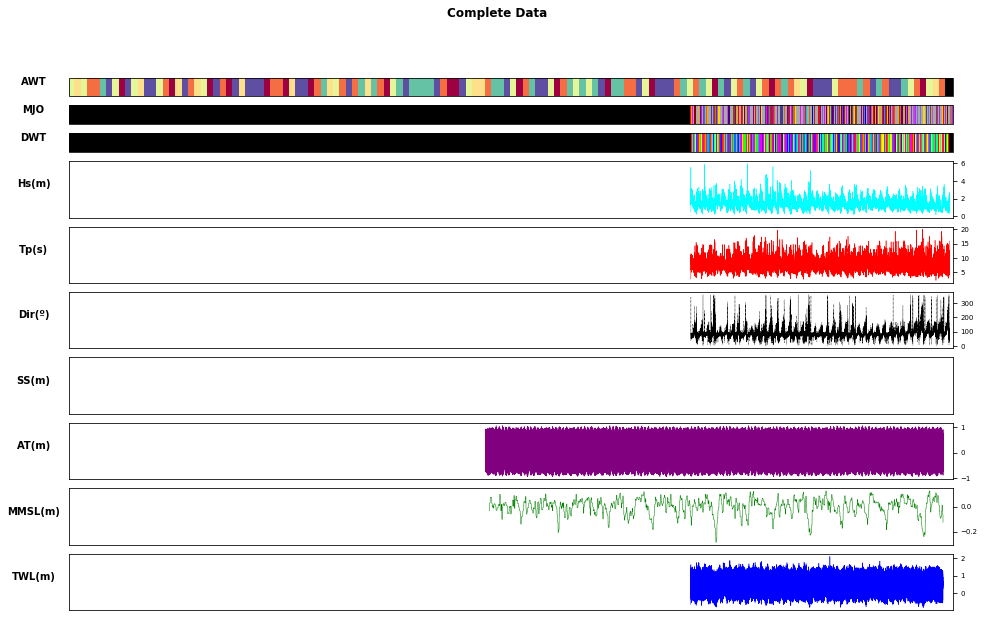

In [4]:
# Plot Historical 
Plot_Complete(HIST);



## Simulated Waves and Climate Data

In [5]:
def waves_hourly(CE, n_sim, n_sim_ce=0):
    '''
    Generate hourly simulation output. 
    
    - select one DWTs-WVS Climate emulator simulations
    - aggregate simulated waves storms
    - generate hourly hydrographs
    
    return xarray.Dataset with dims: time (hourly)
    '''

    # Load DWT --> WVS, TCs simulation 
    WVS_sim, TCS_sim, WVS_upd = CE.LoadSim(n_sim = n_sim)    
    WVS_sim = WVS_sim.isel(n_sim = n_sim_ce)  
    WVS_upd = WVS_upd.isel(n_sim = n_sim_ce)  
    TCS_sim = TCS_sim.isel(n_sim = n_sim_ce)
    
    # Poner NaN en WVS_upd_E donde Hs, Tp y Dir de Swell_1 y Swell_2 valen 0 (Hubo TC y sólo tenemos Sea family)
    vars = {'swell_1_Hs','swell_1_Tp','swell_1_Dir','swell_2_Hs','swell_2_Tp','swell_2_Dir'}
    for var in vars:
        WVS_upd[var] = WVS_upd[var].where(WVS_upd[var]!=0.00, np.nan)

    # aggregate waves families
    WVS_agr = Aggregate_WavesFamilies(WVS_upd, a_tp='max_energy')
    WVS_agr['mslp']=(['time'], WVS_sim.mslp.values)
    WVS_agr['wind_speed']=(['time'], WVS_sim.wind_speed.values)
    WVS_agr['wind_dir']=(['time'], WVS_sim.wind_dir.values)
        
    # calculate intradaily hourly hydrographs for simulated storms
    WVS_h = Intradaily_Hydrograph(WVS_agr, TCS_sim)
        
    # repair times: remove duplicates (if any)
    WVS_h = repair_times_hourly(WVS_h)
    
    # add mask for max_storms times
    WVS_h = add_max_storms_mask(WVS_h, WVS_upd.time.values)

    return WVS_h
    

In [6]:
# generate simulation covariates hourly data 
CVS = db.Generate_SIM_Covariates(total_sims=n_sims_DWTs)

# iterate simulations
for n in range(n_sims_DWTs):
 
    # select covariates simulation
    CVS_s = CVS.sel(n_sim=n)

    # generate hourly waves
    WVS_s = waves_hourly(CE, n)
    
    # merge all data
    d1, d2 = xds_limit_dates([WVS_s, CVS_s])
    WVS_s = WVS_s.sel(time = slice(d1, d2))
    SIM = xr.combine_by_coords([WVS_s, CVS_s])
   
    # set AT reference level (mean at 0)
    SIM['AT'].values[:] = SIM['AT'] - np.nanmean(SIM['AT'])
    
    # calculate AWL, TWL and level
    SIM['AWL'] = AWL(SIM['Hs'], SIM['Tp'])
    SIM['TWL'] = SIM['AWL'] + SIM['SS'] + SIM['AT'] + SIM['MMSL']
    SIM['level'] = SIM['SS'] + SIM['AT'] + SIM['MMSL']
    
    # store hourly simulation offshore data
    db.Save_SIM_OFFSHORE(SIM, n)
    
    print('simulation {0} processed.'.format(n))
    


simulation 0 processed.
simulation 1 processed.
simulation 2 processed.
simulation 3 processed.
simulation 4 processed.
simulation 5 processed.
simulation 6 processed.
simulation 7 processed.
simulation 8 processed.
simulation 9 processed.


In [7]:
# Plot one Simulation 

n_sim = 0
SIM_p = db.Load_SIM_OFFSHORE(n_sim)
print(SIM_p)

#Plot_Complete(SIM_p);


<xarray.Dataset>
Dimensions:     (time: 8765832)
Coordinates:
  * time        (time) int64 262968 262969 262970 ... 9028797 9028798 9028799
Data variables:
    SS          (time) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    MJO         (time) float32 23.0 23.0 23.0 23.0 23.0 ... 18.0 18.0 18.0 18.0
    level       (time) float32 0.26360765 0.31334826 ... -0.44929537 -0.6379945
    wind_dir    (time) float32 57.103546 57.103546 ... 77.984795 77.984795
    TWL         (time) float32 0.6015907 0.6565171 ... -0.19500141 -0.38370055
    AWT         (time) float32 3.0 3.0 3.0 3.0 3.0 3.0 ... 3.0 3.0 3.0 3.0 3.0
    AWL         (time) float32 0.33798307 0.34316885 ... 0.25429398 0.25429398
    max_storms  (time) float32 1.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    MMSL        (time) float32 0.018022971 0.018022971 ... -0.020136157
    Dir         (time) float32 60.549824 60.549824 ... 23.329313 23.329313
    DWT         (time) float32 28.0 28.0 28.0 28.0 28.0 ... 20.0 20

In [8]:
from teslakit.plotting.config import _faspect, _fsize, _fdpi
from teslakit.plotting.outputs import axplot_bmus, axplot_series
from matplotlib import gridspec

def Plot_Complete(xds):

    # parameters
    n_cs_AWT = 6
    n_cs_MJO = 25
    n_cs_DWT = 42


    # plot figure
    fig, axs = plt.subplots(
        13, 1,
        figsize=(_faspect*_fsize, _fsize),
    )

    # AWT
    axplot_bmus(axs[0], xds.AWT, n_cs_AWT, 'AWT')

    # MJO
    axplot_bmus(axs[1], xds.MJO, n_cs_MJO, 'MJO')

    # DWT
    axplot_bmus(axs[2], xds.DWT, n_cs_DWT, 'DWT')

    # HS
    axplot_series(axs[3], xds.Hs, 'solid', 'royalblue', 'Hs(m)')

    # TP
    axplot_series(axs[4], xds.Tp, 'solid', 'crimson', 'Tp(s)')

    # DIR
    axplot_series(axs[5], xds.Dir, 'dotted', 'black', 'Dir(º)')

    # SS
    axplot_series(axs[6], xds.SS, 'solid', 'orange', 'SS(m)')
        
    # MSLP
    axplot_series(axs[7], xds.mslp*0.01, 'solid', 'darkmagenta', 'mslp(mbar)')

    # WIND-DIR
    axplot_series(axs[8], xds.wind_dir, 'dotted', 'mediumseagreen', 'Wind Dir(°)')

    # WIND-SPEED
    axplot_series(axs[9], xds.wind_speed, 'solid', 'coral', 'Wind Speed(m/s)')

    # AT
    axplot_series(axs[10], xds.AT, 'solid', 'violet', 'AT(m)')

    # MMSL
    axplot_series(axs[11], xds.MMSL, 'solid', 'darkolivegreen', 'MMSL(m)')

    # TWL
    axplot_series(axs[12], xds.TWL, 'solid', 'mediumblue', 'TWL(m)')


    # suptitle
    fig.suptitle('Complete Data', fontweight='bold', fontsize=12)

    # reduce first 3 subplots
    gs = gridspec.GridSpec(13, 1, height_ratios = [1,1,1,3,3,3,3,3,3,3,3,3,3])
    for i in range(13):
        axs[i].set_position(gs[i].get_position(fig))
    
    plt.show()

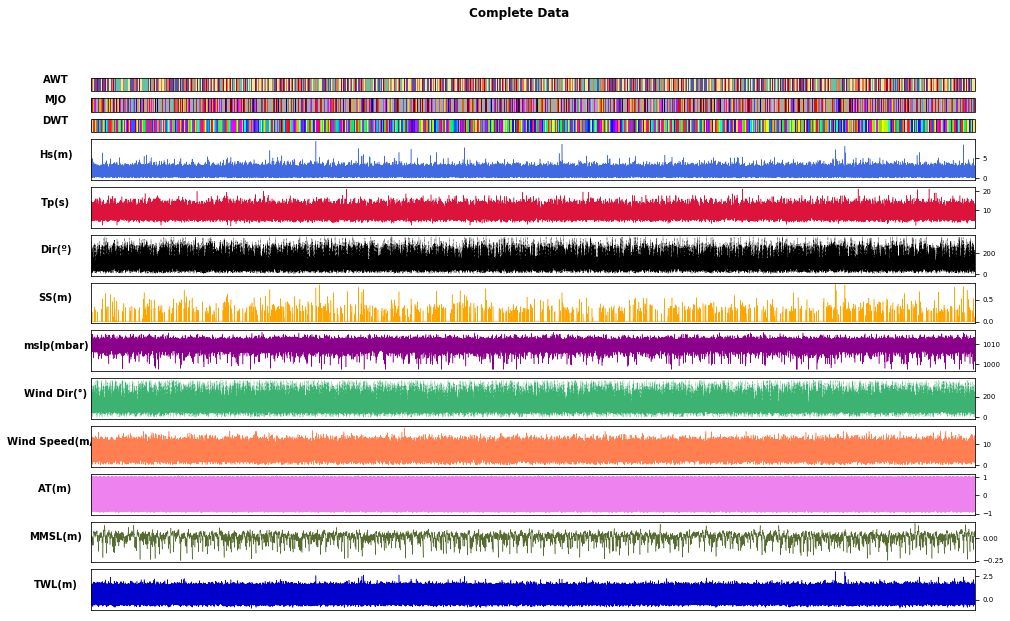

In [9]:
Plot_Complete(SIM_p)